In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla ,group_delay, GroupDelay

# Tamaño de las figuras
fig_sz_x = 14
fig_sz_y = 7

# Tamaño de la tipografía
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2



In [2]:


def plot_iir_response(sos_iir, iir_lbl = 'un_IIR'):

    w_rad  = np.append(np.logspace(-3, 0.8, 1000), np.logspace(0.9, 1.8, 1000) )
    w_rad  = np.append(w_rad, np.linspace(64, nyq_frec, 1000, endpoint=True) ) / nyq_frec * np.pi
    
    _, h_iir = sig.freqz_sos(sos_iir, worN=w_rad)
    
    w = w_rad / np.pi * nyq_frec
    
    this_lbl = iir_lbl + ' {:d}'.format(sos_iir.shape[0]*2)
    
    plt.figure(1)
    
    plt.plot(w, 20*np.log10(np.abs(h_iir)+1e-12), label= this_lbl )

        
                
    plt.figure(2)
    
    phase_fir = np.angle(h_iir)
    
    plt.plot(w, phase_fir, label= this_lbl)    # Bode phase plot
    
    plt.figure(3)
    
    gd_fir = group_delay(w_rad, phase_fir)
    
    # Para órdenes grandes 
    plt.plot(w[gd_fir > 0], gd_fir[gd_fir>0], label=this_lbl )    # Bode phase plot
    
    return int(np.round(np.median(gd_fir[np.bitwise_and(w > 3, w < 20)])))

## Parte 1: Diseño de filtros

Procedo a diseñar los filtros tal que cumplan con la plantilla

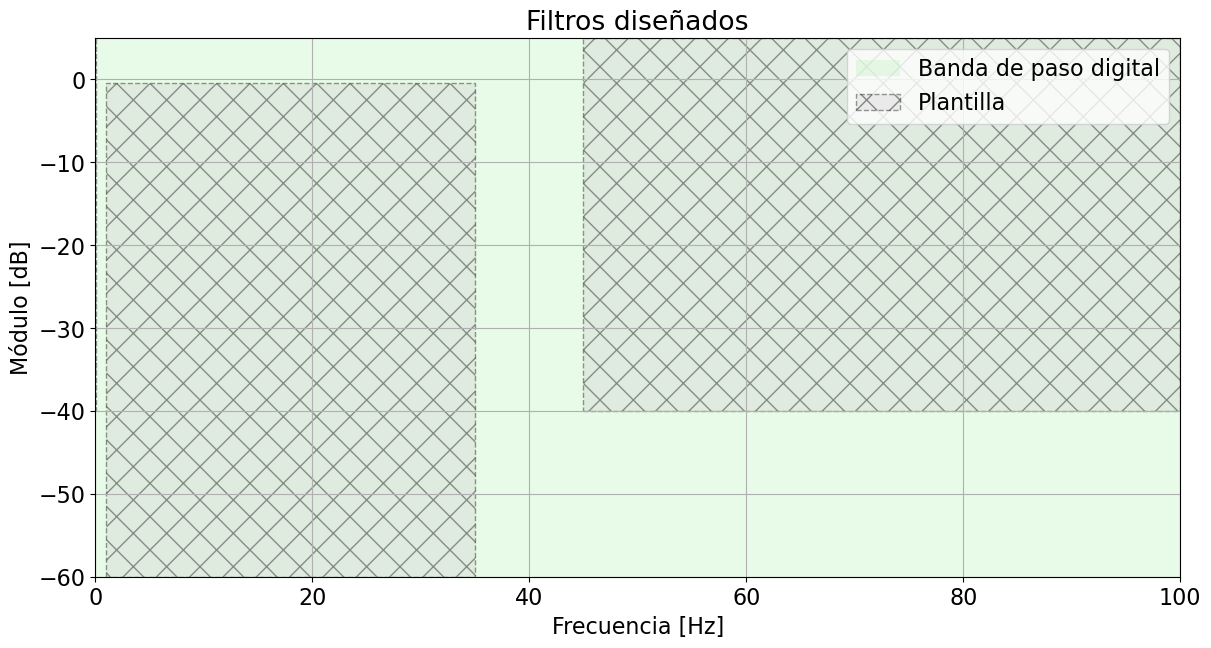

In [3]:
# Plantilla

# filter design
ripple = 0.5 # dB
atenuacion = 40 # dB

ws1 = .1 #Hz
wp1 = 1 #Hz
wp2 = 35.0 #Hz
ws2 = 45.0 #Hz

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))
plt.axis([0, 100, -60, 5 ]);

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)


plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
_ = plt.legend()



### Filtro IIR

50


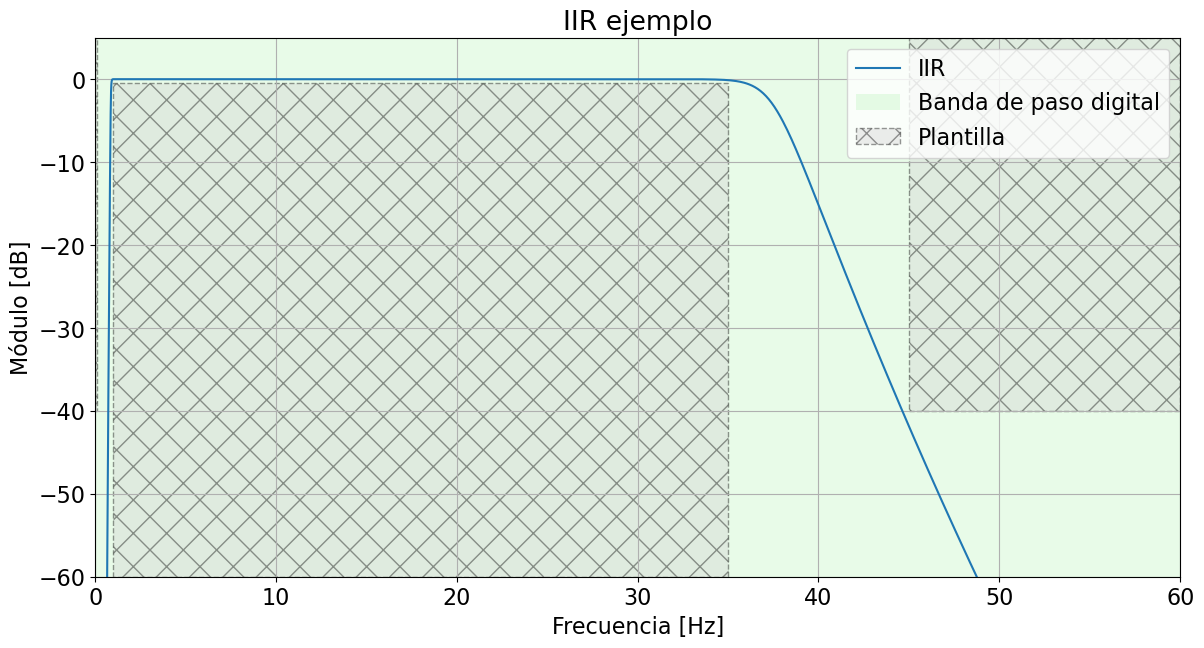

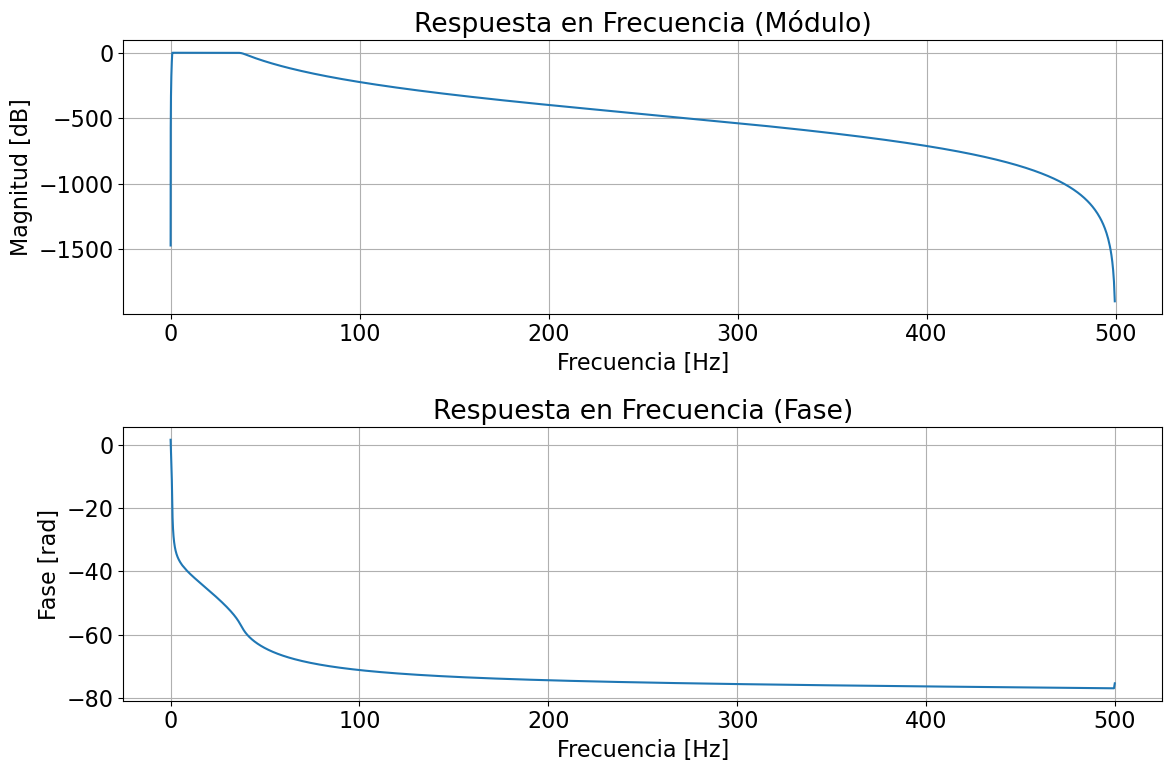

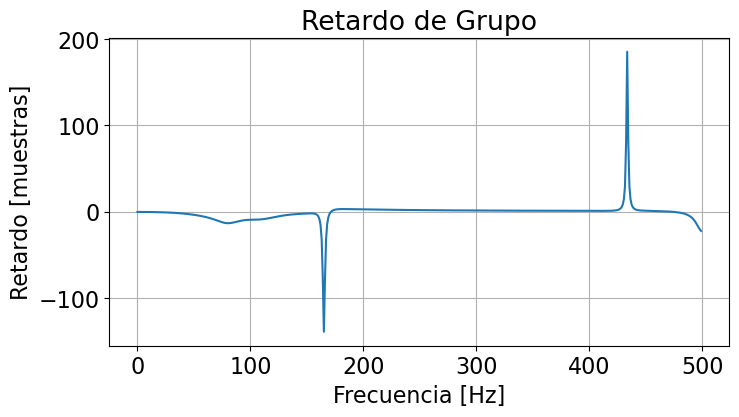

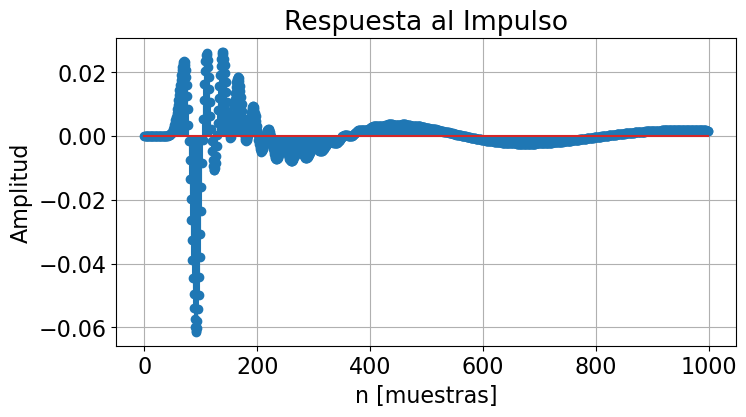

In [4]:

sos_iir = sig.iirdesign(wp=[wp1-0.1,wp2+1], ws=[ws1,ws2], gpass=ripple, gstop=atenuacion, output='sos', analog=False, ftype='butter', fs = fs)

w_rad  = np.append(np.logspace(-3, 0.8, 1000), np.logspace(0.9, 1.8, 1000) )
w_rad  = np.append(w_rad, np.linspace(64, nyq_frec, 1000, endpoint=True) )

w_rad, h_iir = sig.freqz_sos(sos_iir, worN=w_rad, fs = fs)

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))

plt.plot(w_rad, 20*np.log10(np.abs(h_iir)+1e-12), label = 'IIR' )

plt.title('IIR ejemplo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)
_ = axes_hdl.legend()
print(sos_iir.shape[0]*2)

w, h = sig.sosfreqz(sos_iir, worN=w_rad, fs=fs)

plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.plot(w, 20*np.log10(np.abs(h)))
plt.title("Respuesta en Frecuencia (Módulo)")
plt.ylabel("Magnitud [dB]")
plt.xlabel("Frecuencia [Hz]")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(w, np.unwrap(np.angle(h)))
plt.title("Respuesta en Frecuencia (Fase)")
plt.ylabel("Fase [rad]")
plt.xlabel("Frecuencia [Hz]")
plt.grid(True)

plt.tight_layout()
plt.show()

# -------------------------------------------------
# Retardo de grupo
# -------------------------------------------------
w_gd, gd = sig.group_delay((sig.sos2tf(sos_iir)), fs=fs)

plt.figure(figsize=(8,4))
plt.plot(w_gd, gd)
plt.title("Retardo de Grupo")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Retardo [muestras]")
plt.grid(True)
plt.show()

# -------------------------------------------------
# Respuesta al impulso
# -------------------------------------------------
imp = np.zeros(1000)
imp[0] = 1
imp_resp = sig.sosfilt(sos_iir, imp)

plt.figure(figsize=(8,4))
plt.stem(imp_resp)
plt.title("Respuesta al Impulso")
plt.xlabel("n [muestras]")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show() 



### Filtros FIR


#### Filtro FIR con Ventana

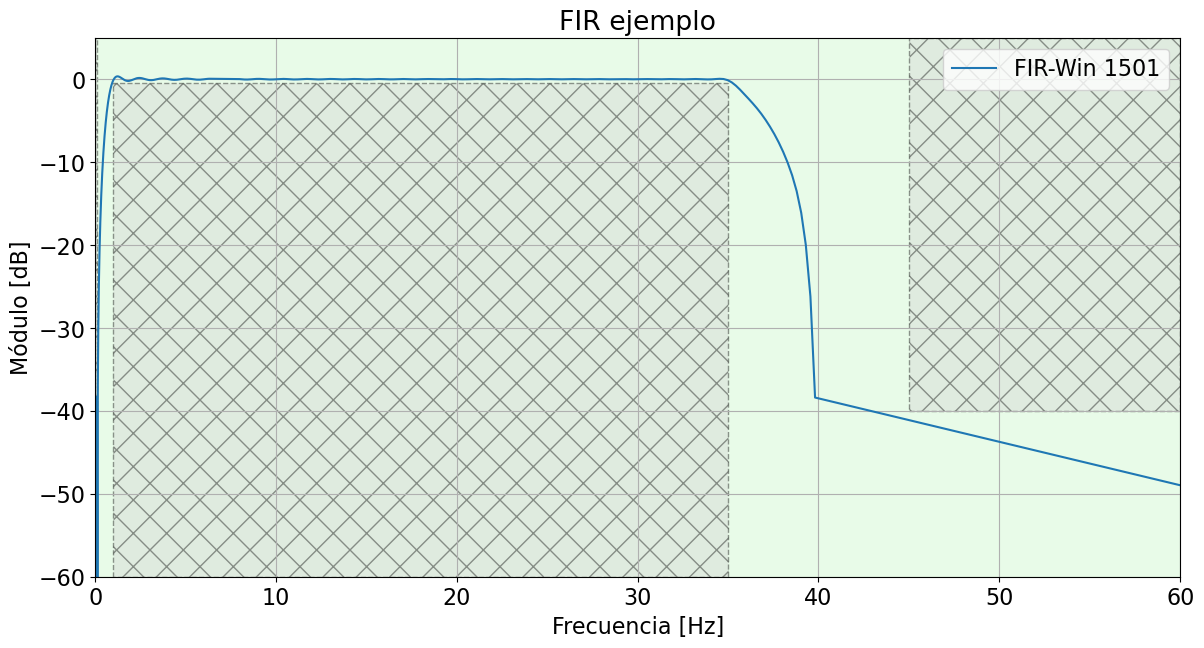

In [5]:
ws1_fir = .2 #Hz
wp1_fir = 0.9 #Hz
wp2_fir = 35.0 #Hz
ws2_fir = 39.8 #Hz


# se fija una cantidad de coeficientes para la respuesta del FIR
cant_coeficientes = 1501

# algoritmo de diseño, se obtienen los coeficientes del numerador
num_win1 = sig.firwin2(cant_coeficientes, freq = (0, ws1_fir, wp1_fir, wp2_fir , ws2_fir, nyq_frec), gain = (0, 0, 1, 1, 0, 0) , window='boxcar', fs = fs )

# coeficientes del denominador
den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) )

_, hh_win = sig.freqz(num_win1, den, w, fs = fs)

plt.figure(1, figsize=(fig_sz_x, fig_sz_y))

plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win1.shape[0]))

plt.title('FIR ejemplo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5 ]);

axes_hdl = plt.gca()
axes_hdl.legend()

plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)
plt.show()





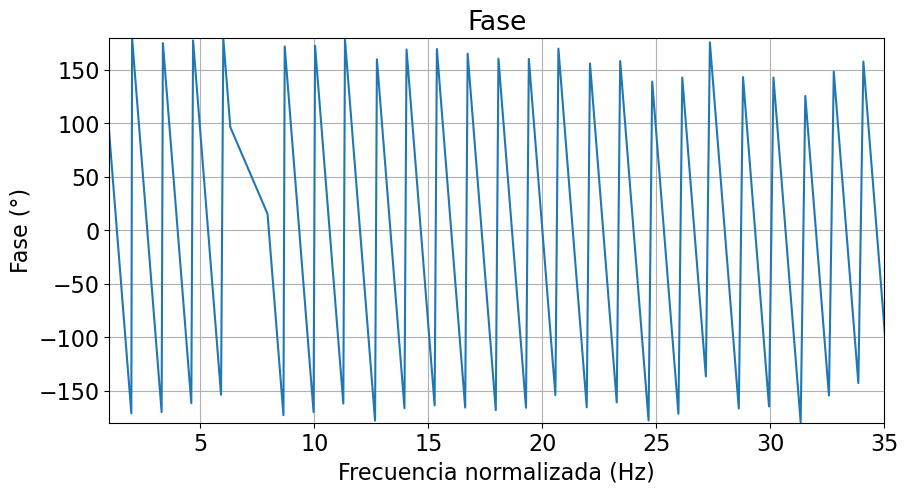

In [6]:
# --- Graficar Fase ---
plt.show()
plt.figure(1, figsize=(10, 5))
plt.plot(w,np.angle(hh_win,deg='True'), label='FIR-LS {:d}'.format(num_win1.shape[0]))
plt.title("Fase")
plt.xlabel("Frecuencia normalizada (Hz)")
plt.ylabel("Fase (°)")
plt.axis([1, 35, -180, 180])
plt.grid()
plt.show()


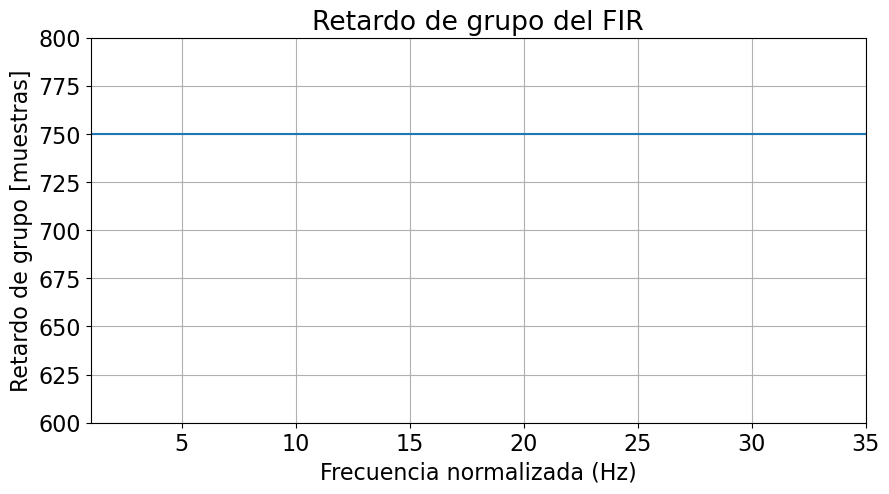

In [7]:
# --- Calcular retardo de grupo ---
w, gd = sig.group_delay((num_win1, 1), fs = fs)
plt.figure(1, figsize=(10, 5))
# --- Graficar ---
plt.plot(w, gd)
plt.title("Retardo de grupo del FIR")
plt.xlabel("Frecuencia normalizada (Hz)")
plt.ylabel("Retardo de grupo [muestras]")
plt.grid(True)
plt.axis([1, 35, 600, 800])
plt.show()


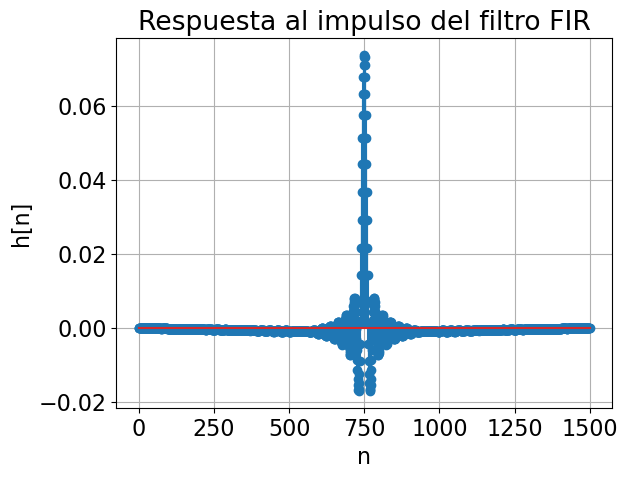

In [8]:

imp_resp = num_win1
n = np.arange(0, len(num_win1))
# --- Graficar Respuesta al impulso ---
plt.stem(n, imp_resp)
plt.title("Respuesta al impulso del filtro FIR")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid(True)
plt.show()

#### Filtro FIR con Cuadrados minimos (FIRLS)

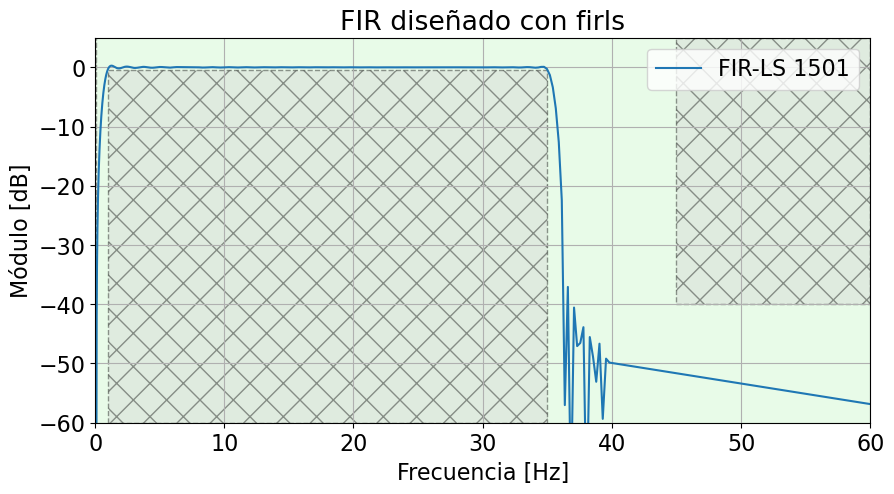

In [9]:
# import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

# Frecuencias de la plantilla
ws1_fir = 0.2   # Hz
wp1_fir = 0.9   # Hz
wp2_fir = 35.0  # Hz
ws2_fir = 36.2  # Hz

# Parámetros generales
fs = 1e3      # Hz (ejemplo, pon tu valor real)
nyq_frec = fs / 2

# Número de coeficientes
cant_coeficientes = 1501

# Defino bandas y respuesta deseada
bands   = [0, ws1_fir, wp1_fir, wp2_fir, ws2_fir, nyq_frec]
desired = [0, 0,       1,       1,       0,       0]

# Diseño con firls
num_sqmin = sig.firls(cant_coeficientes, bands, desired, fs=fs)

# Coeficiente del denominador
den = 1.0

# Frecuencias para graficar
w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250))
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True))

_, hh_win = sig.freqz(num_sqmin, den, w, fs=fs)

# Graficar
plt.figure(1, figsize=(10, 5))
plt.plot(w, 20 * np.log10(abs(hh_win)), label='FIR-LS {:d}'.format(num_sqmin.shape[0]))

plt.title('FIR diseñado con firls')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 60, -60, 5])
plt.legend()
plot_plantilla(filter_type = 'bandpass', fpass = (wp1, wp2), fstop =  (ws1, ws2), ripple = ripple, attenuation = atenuacion, fs = fs)
plt.show()





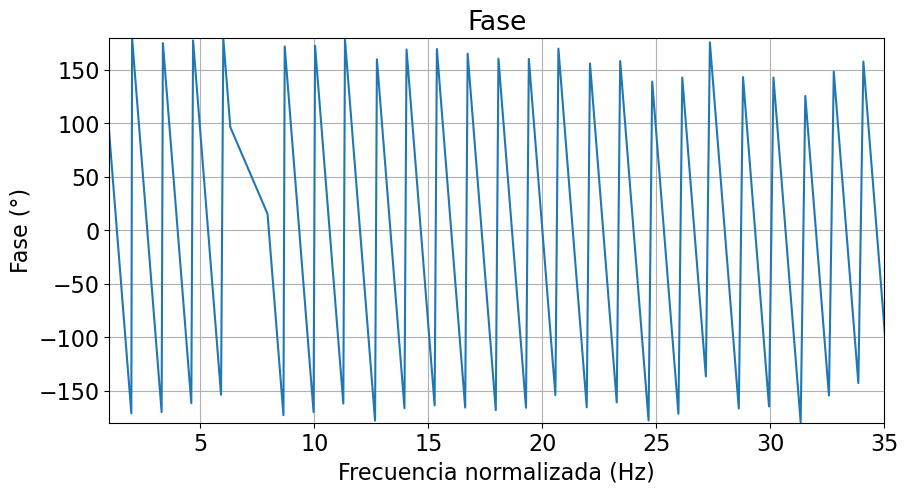

In [10]:
# --- Graficar Fase ---
plt.figure(1, figsize=(10, 5))
plt.plot(w,np.angle(hh_win,deg='True'), label='FIR-LS {:d}'.format(num_win1.shape[0]))
plt.title("Fase")
plt.xlabel("Frecuencia normalizada (Hz)")
plt.ylabel("Fase (°)")
plt.axis([1, 35, -180, 180])
plt.grid()
plt.show()


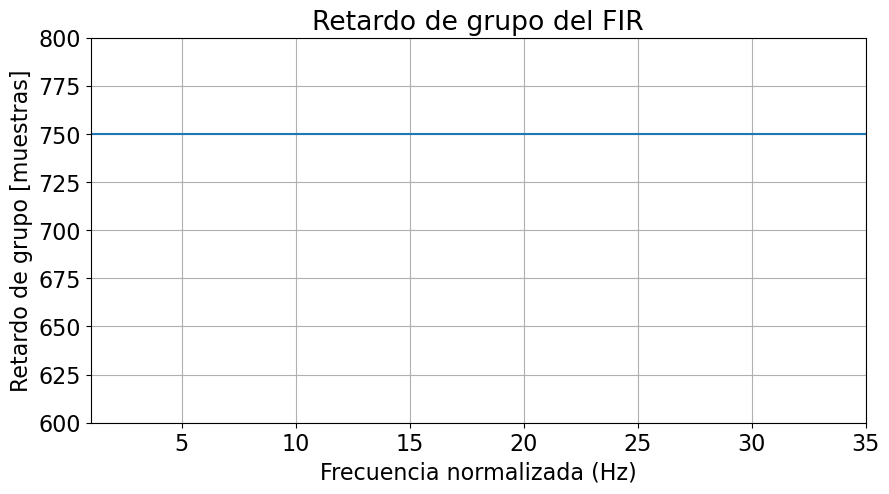

In [11]:
# --- Calcular retardo de grupo ---
w, gd = sig.group_delay((num_sqmin, 1), fs = fs)
plt.figure(1, figsize=(10, 5))
# --- Graficar ---
plt.plot(w, gd)
plt.title("Retardo de grupo del FIR")
plt.xlabel("Frecuencia normalizada (Hz)")
plt.ylabel("Retardo de grupo [muestras]")
plt.grid(True)
plt.axis([1, 35, 600, 800])
plt.show()

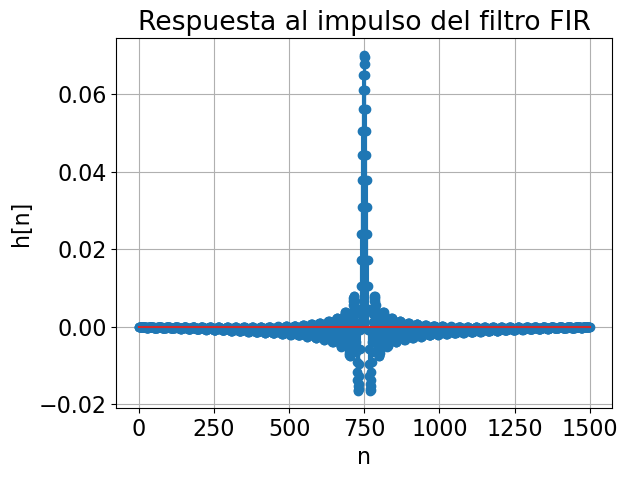

In [12]:
imp_resp = num_sqmin
n = np.arange(0, len(num_sqmin))

plt.stem(n, imp_resp)
plt.title("Respuesta al impulso del filtro FIR")
plt.xlabel("n")
plt.ylabel("h[n]")
plt.grid(True)
plt.show()

## Aplicación de los filtros a una señal de ECG

In [13]:
# IIR
#ECG_f_butt = sig.sosfilt(sos_iir , ecg_one_lead)

# FIR
#ECG_f_win1 = sig.lfilter(num_win1, den, ecg_one_lead)
#ECG_f_sqmin = sig.lfilter(num_sqmin, den, ecg_one_lead)


# IIR
ECG_f_butt = sig.sosfiltfilt(sos_iir , ecg_one_lead)

# FIR
ECG_f_win1 = sig.filtfilt(num_win1, den, ecg_one_lead)
ECG_f_sqmin = sig.filtfilt(num_sqmin, den, ecg_one_lead)


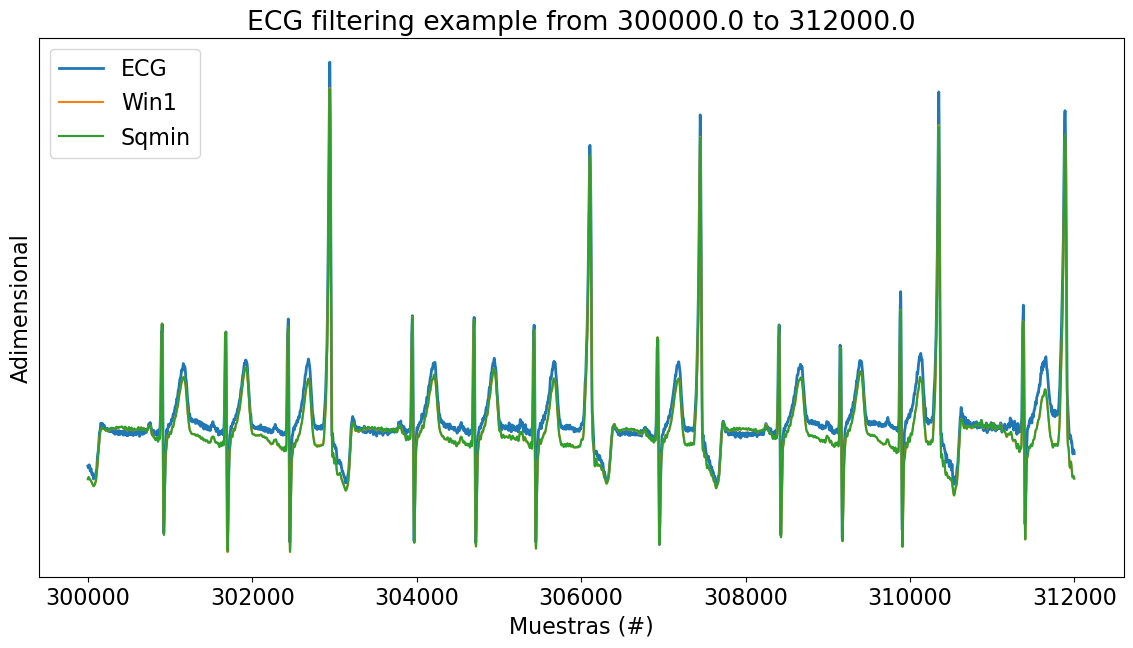

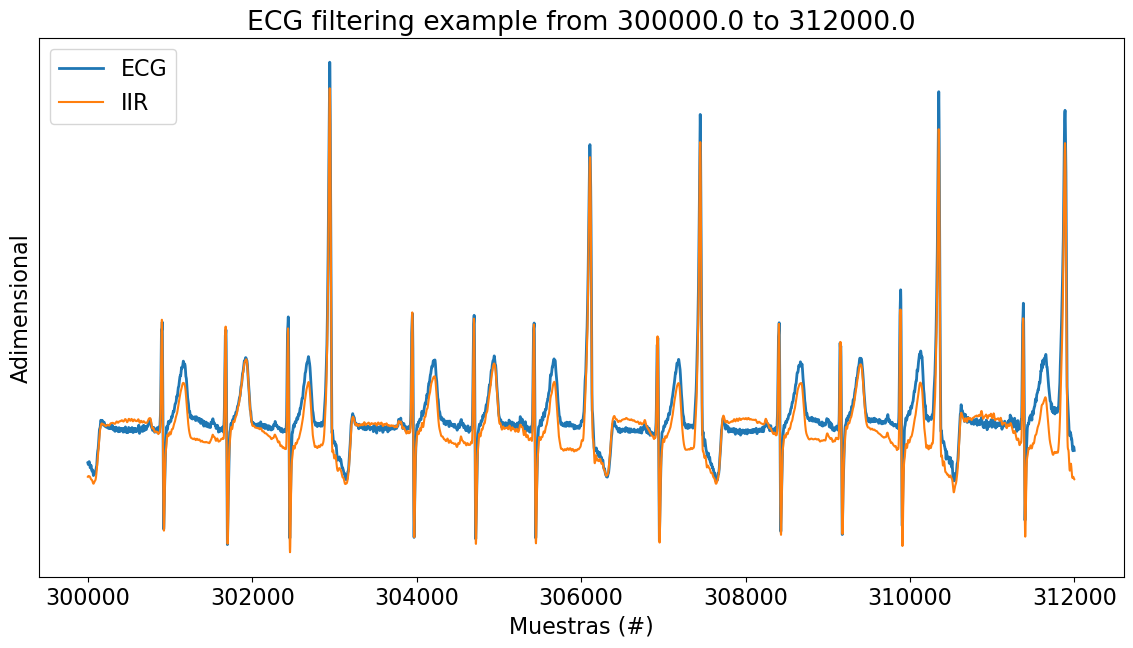

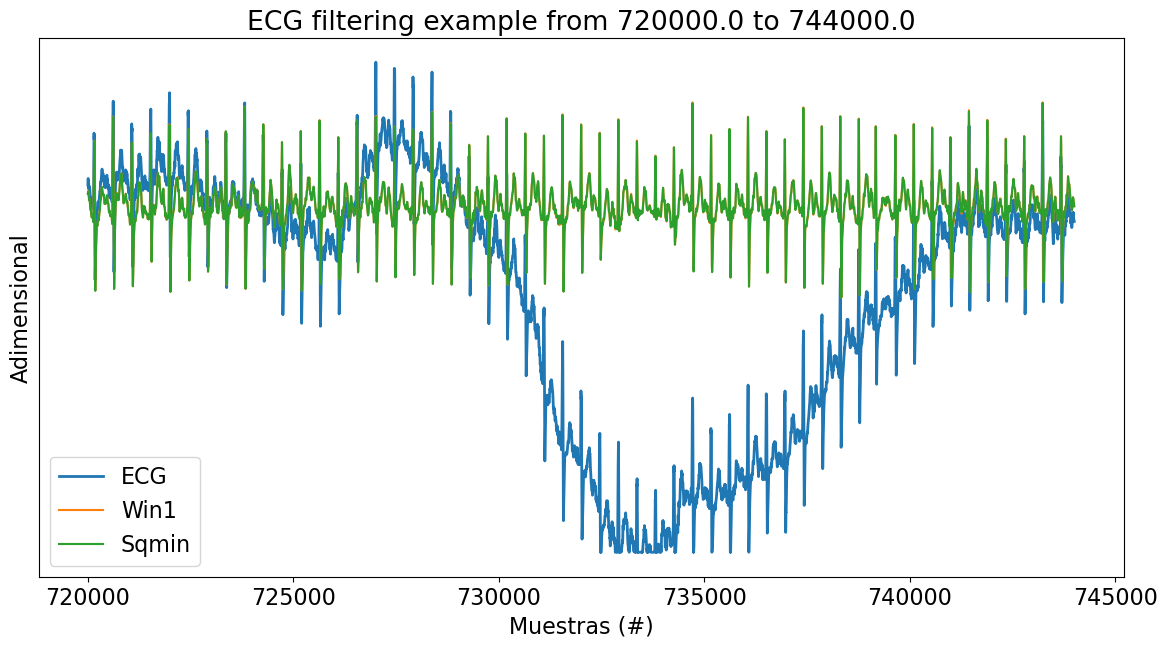

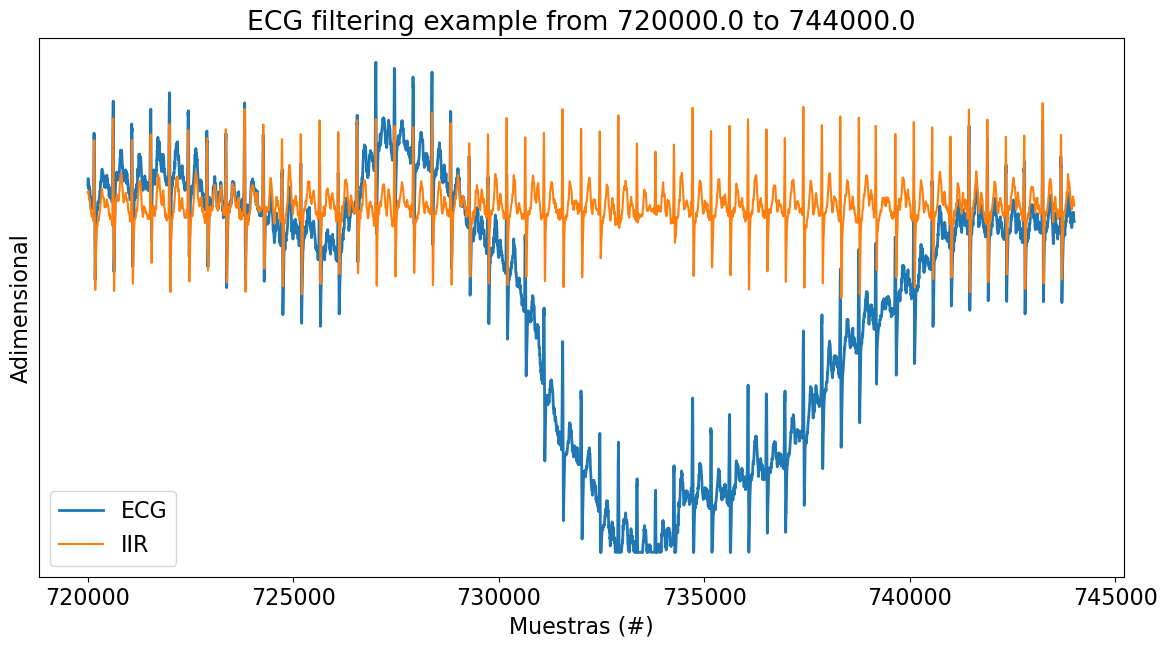

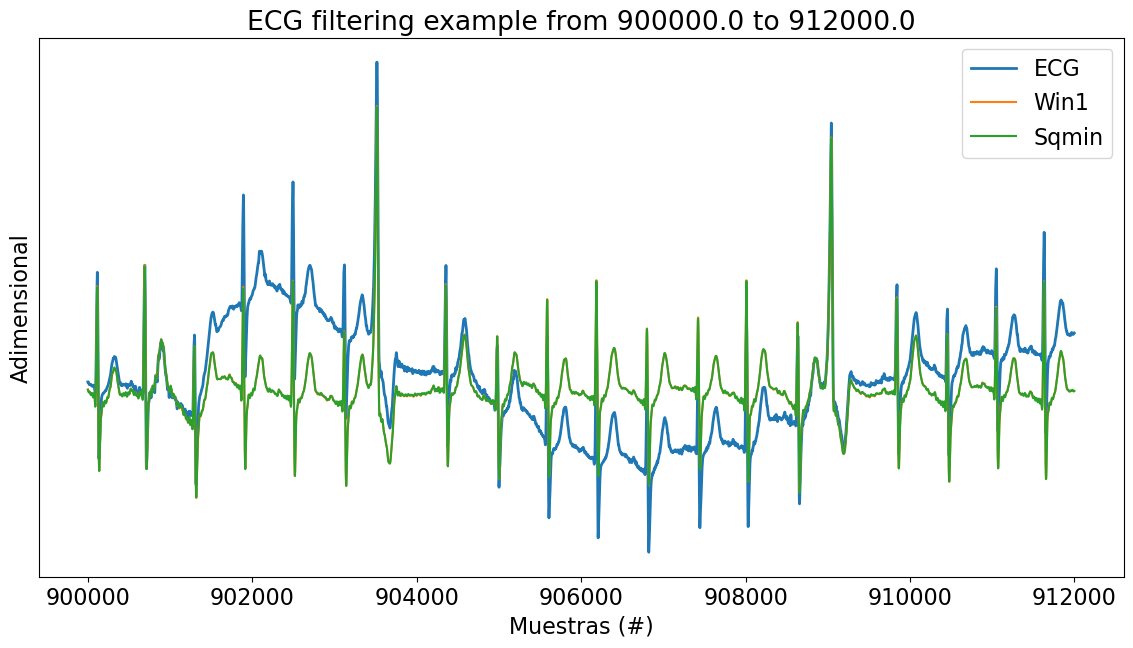

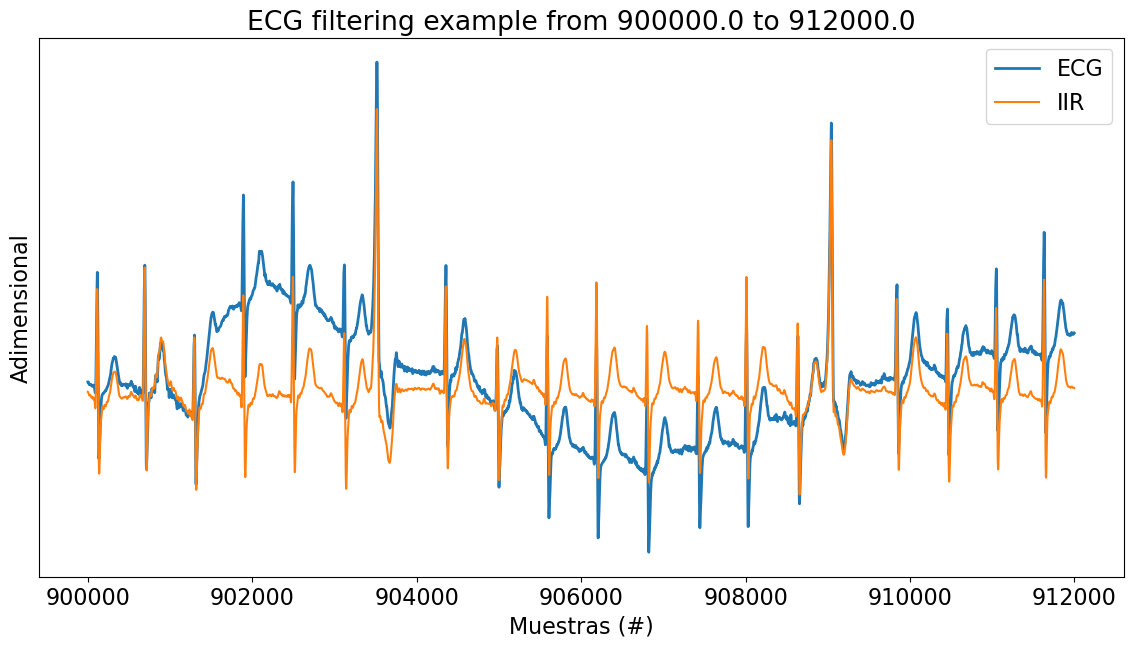

In [14]:
# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 0


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    
    plt.plot(zoom_region, ECG_f_win1[zoom_region + demora], label='Win1')
    plt.plot(zoom_region, ECG_f_sqmin[zoom_region + demora], label='Sqmin')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='IIR')
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

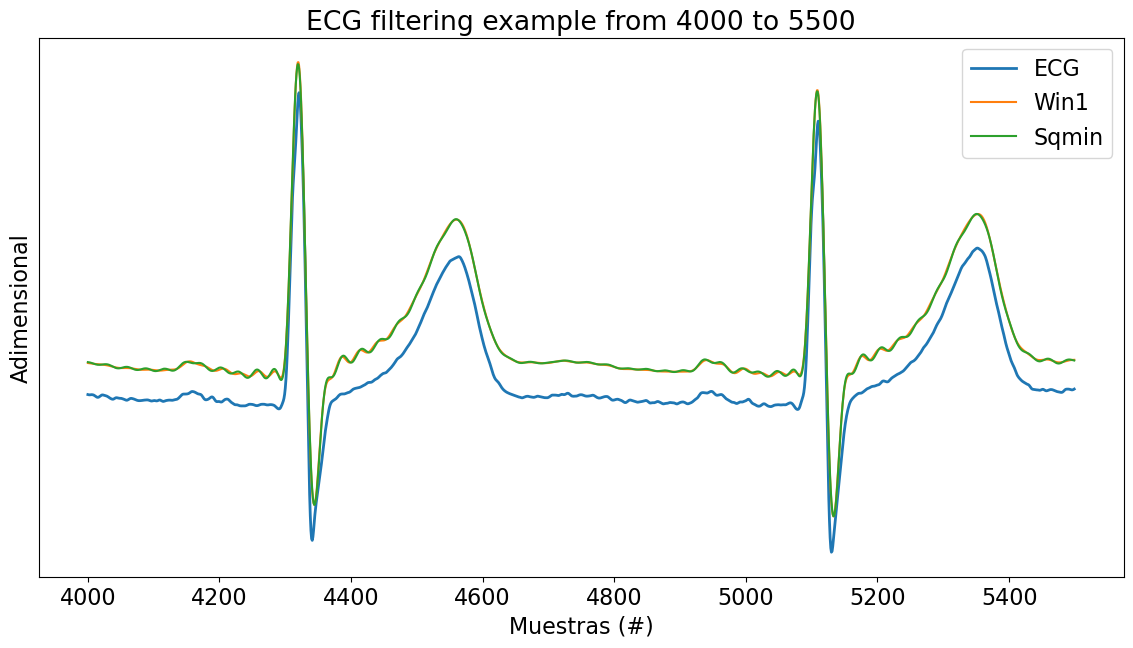

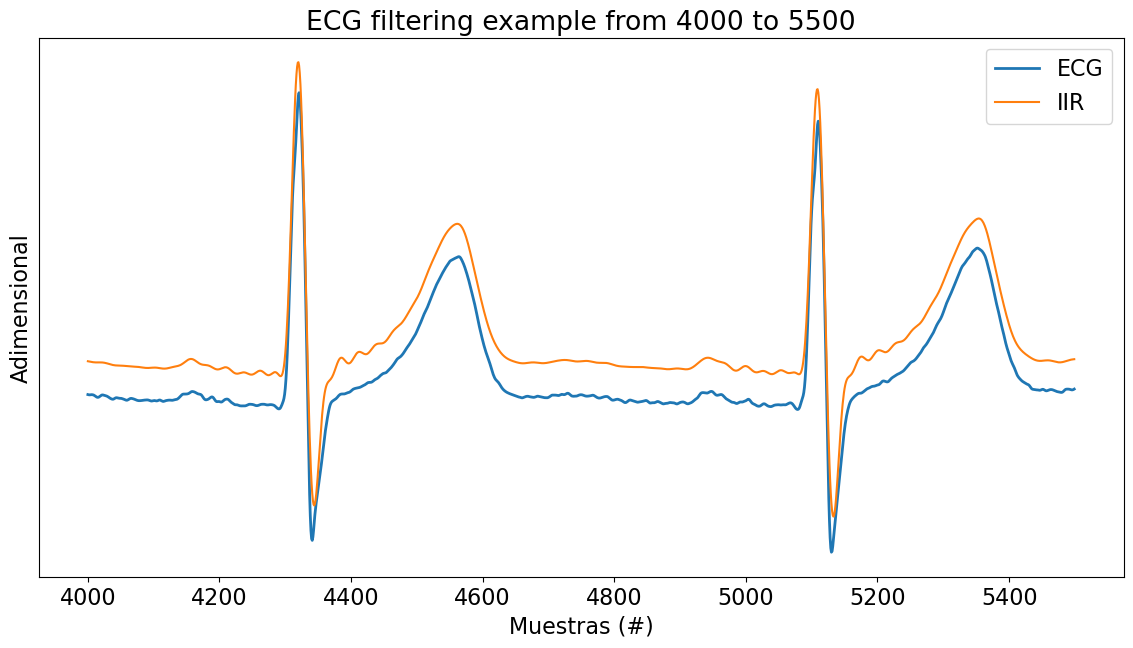

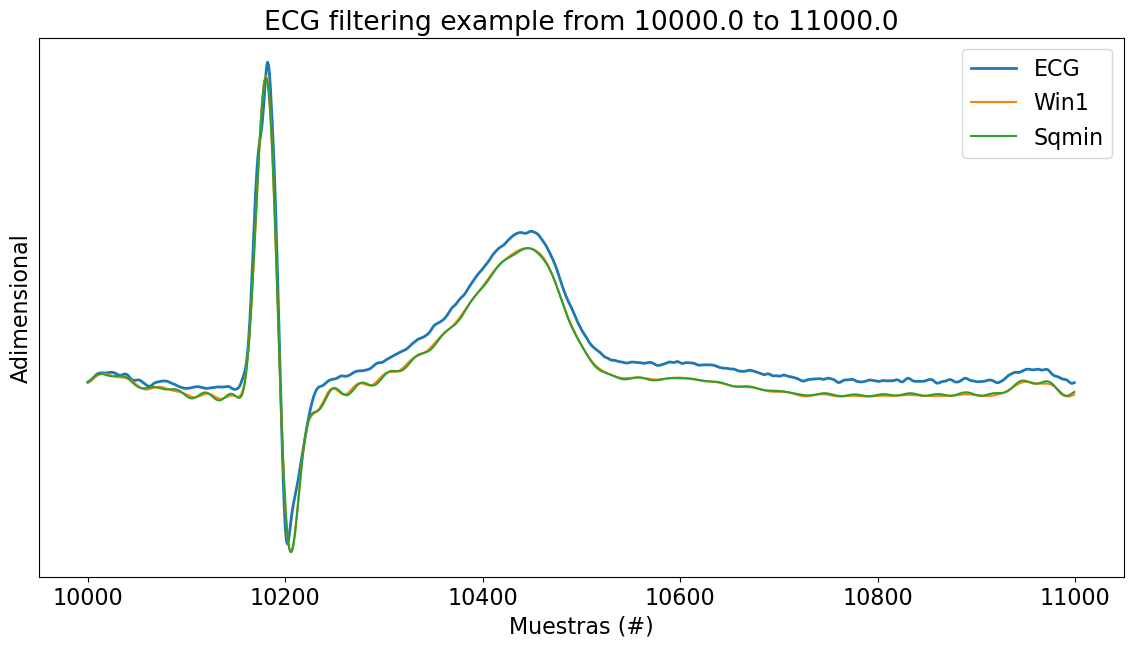

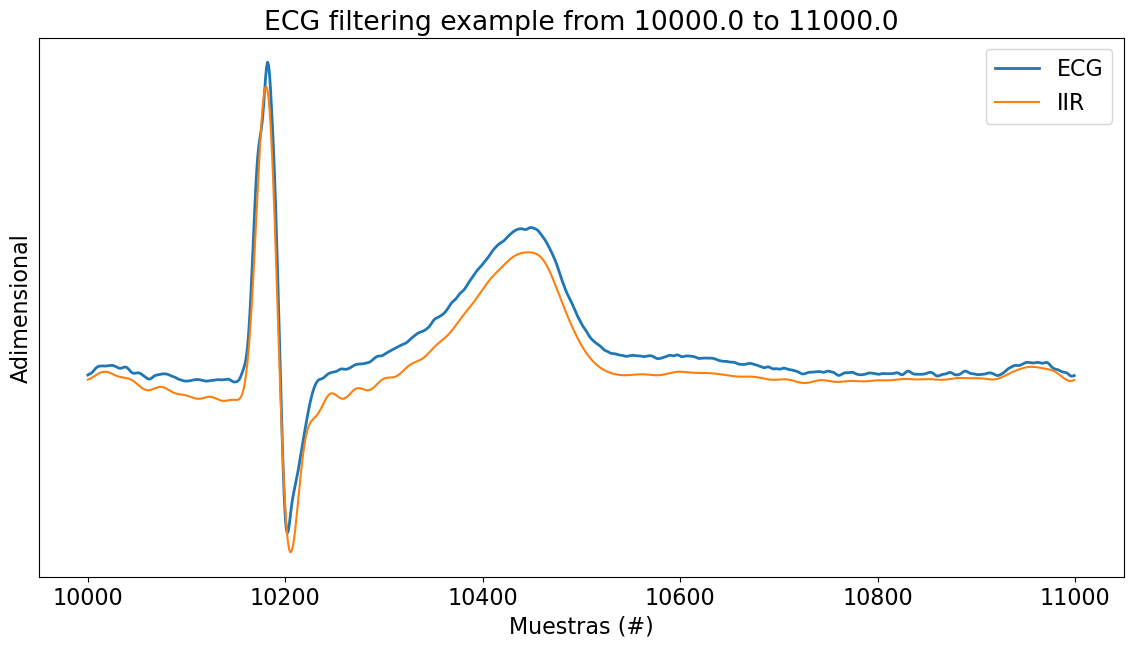

In [15]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win1[zoom_region + demora], label='Win1')
    plt.plot(zoom_region, ECG_f_sqmin[zoom_region + demora], label='Sqmin')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='IIR')
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

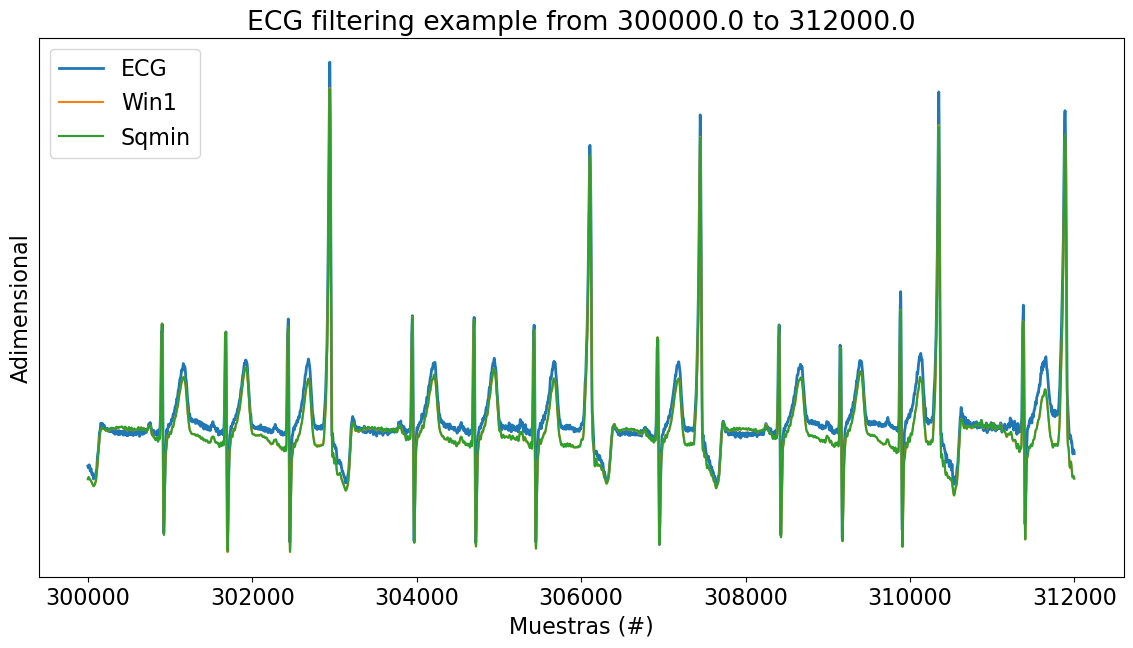

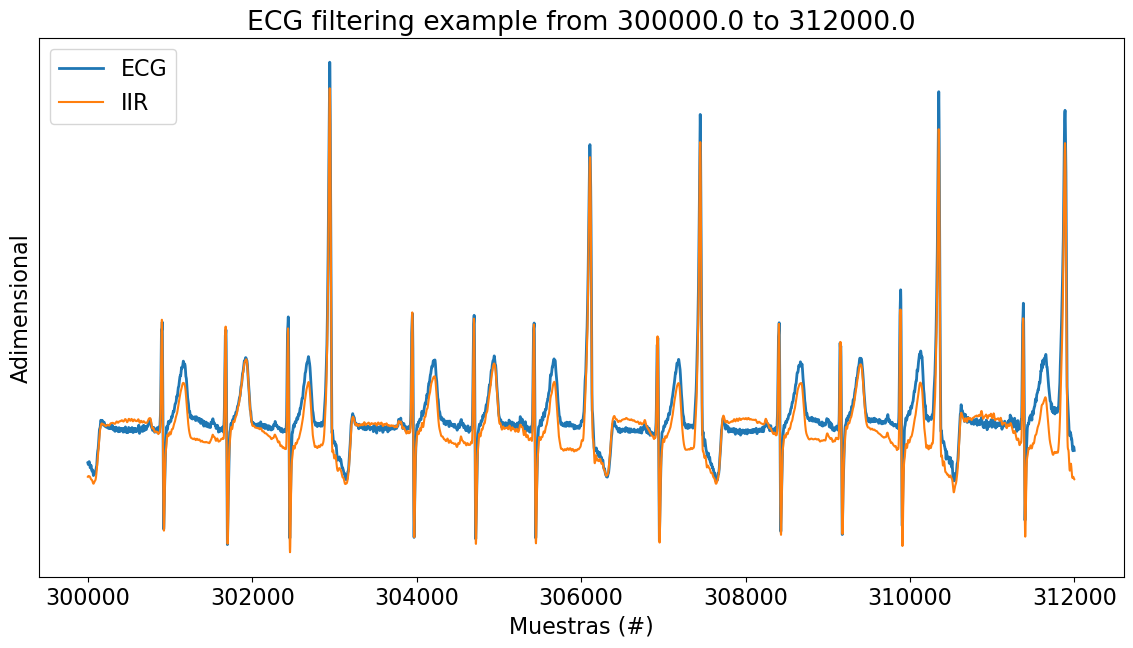

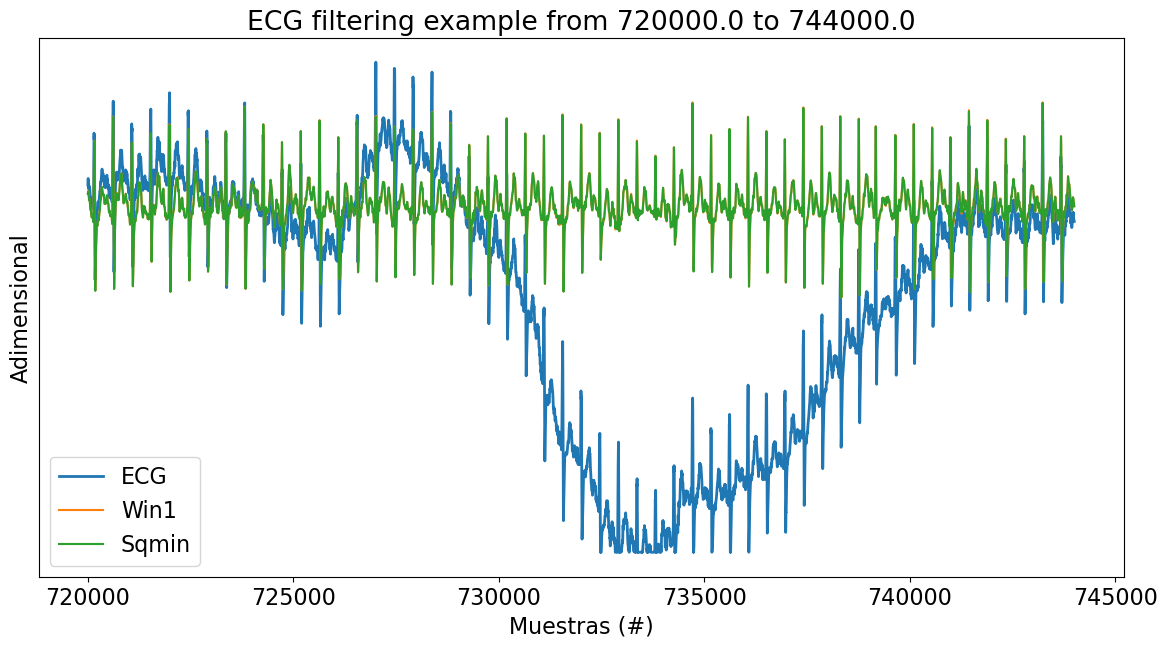

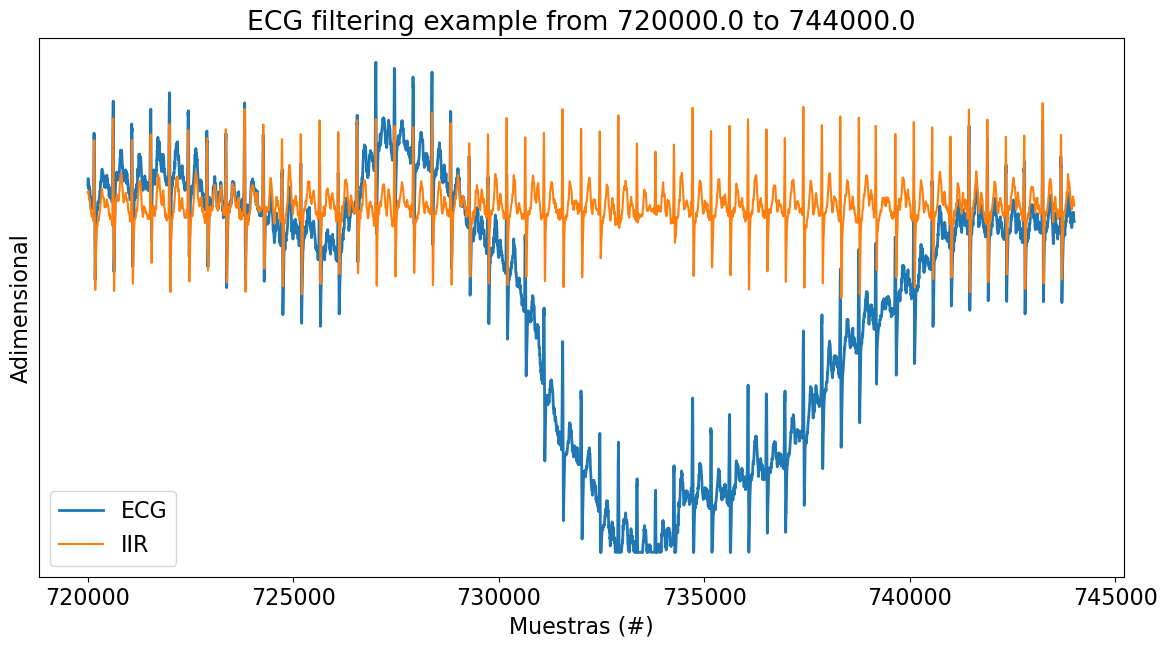

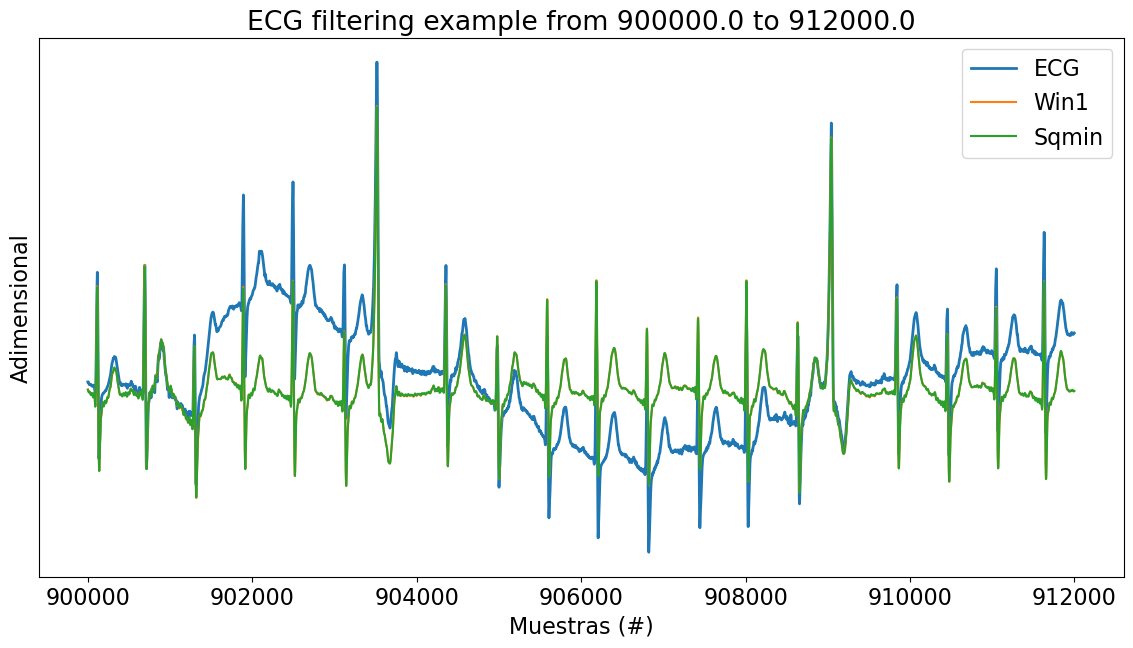

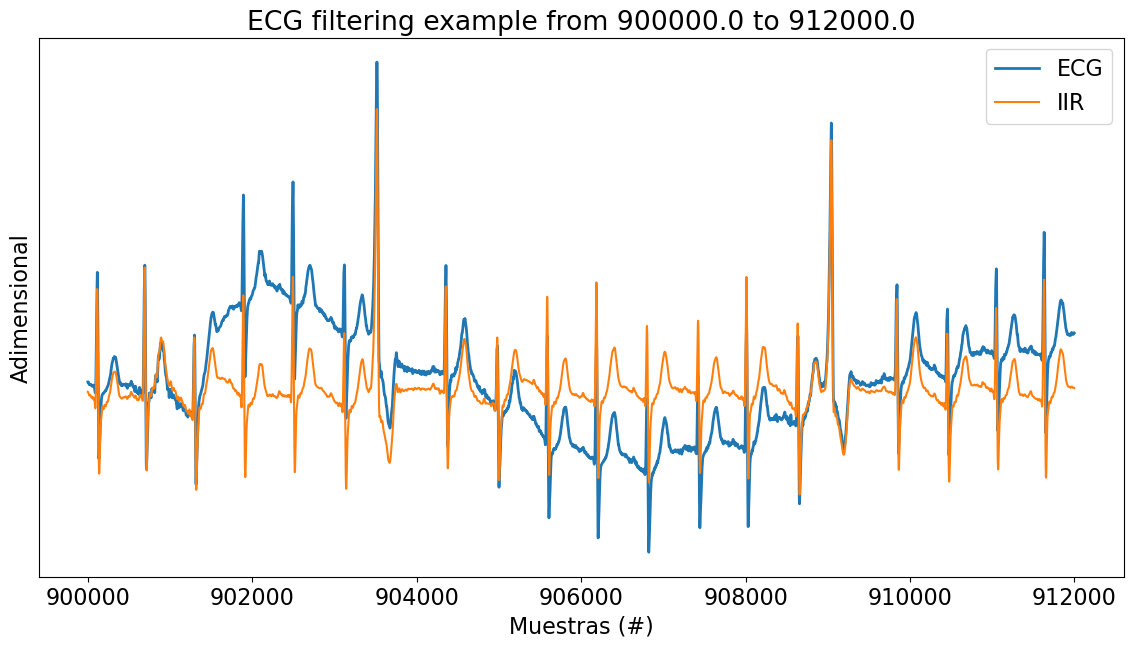

In [16]:


# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win1[zoom_region + demora], label='Win1')
    plt.plot(zoom_region, ECG_f_sqmin[zoom_region + demora], label='Sqmin')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='IIR')
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

Volvemos a revisar los detalles menos contaminados:

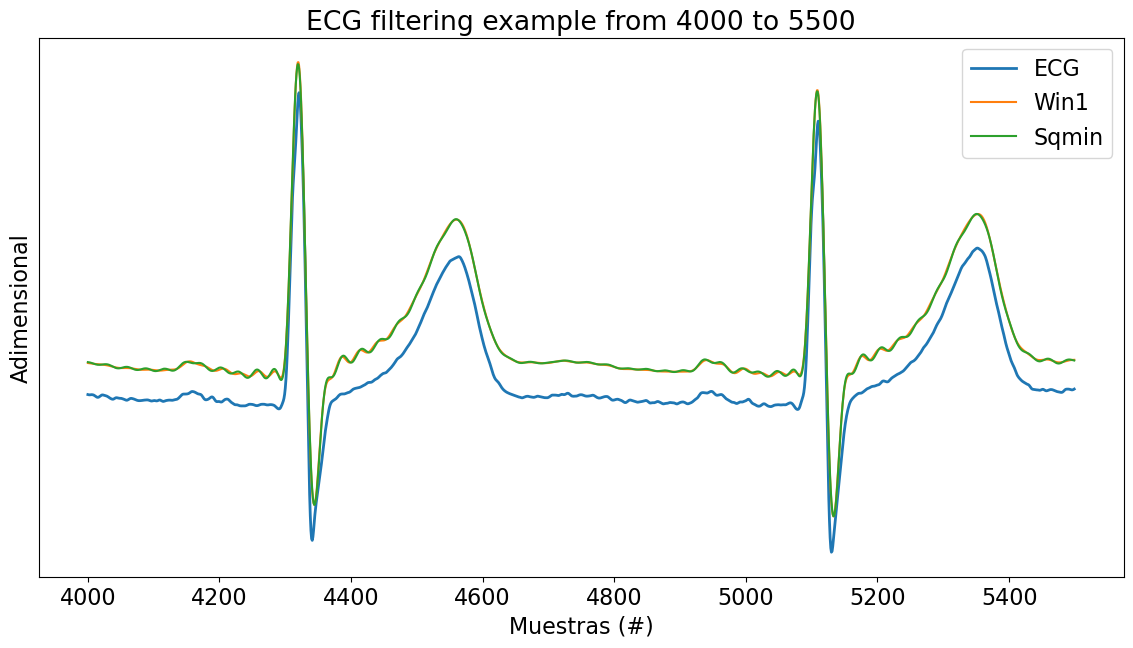

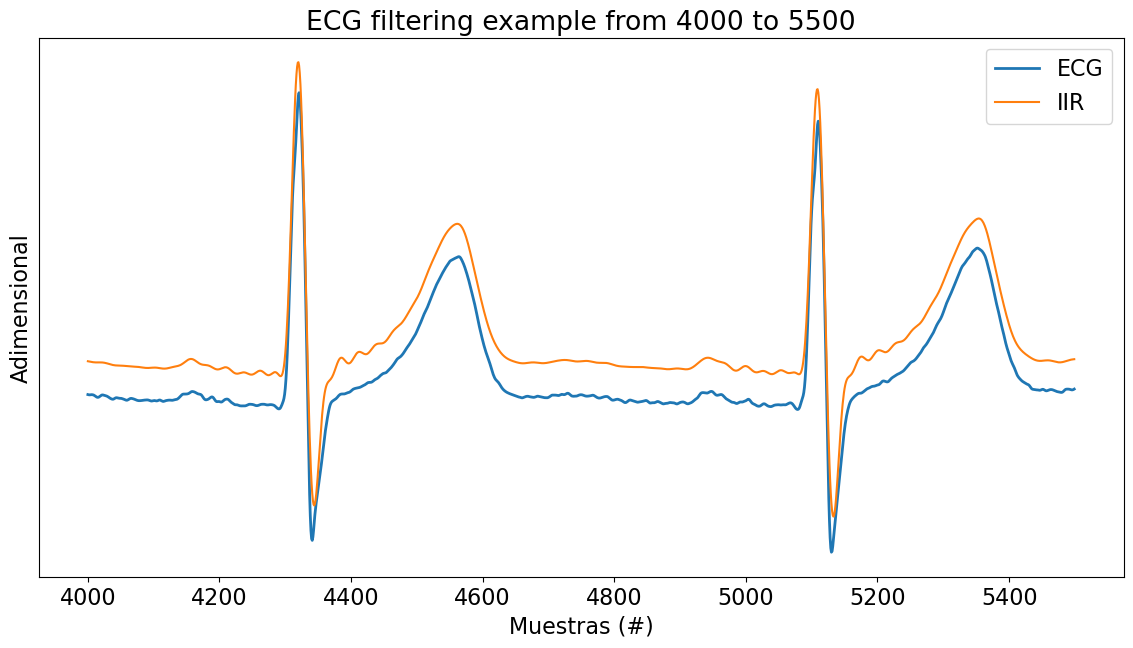

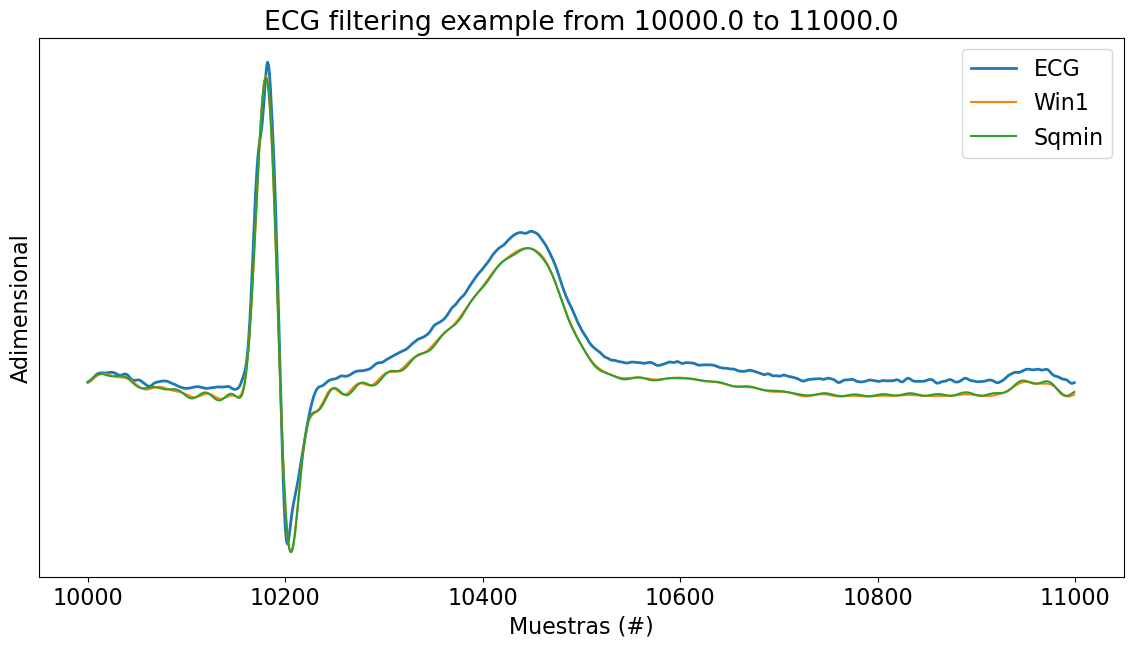

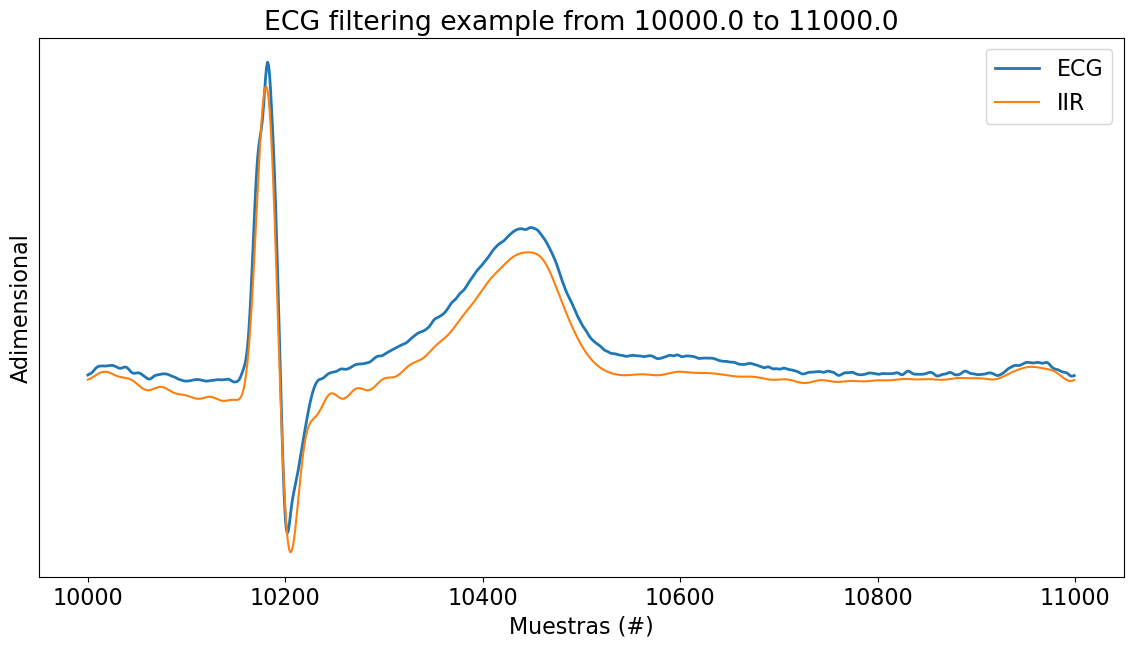

In [17]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win1[zoom_region + demora], label='Win1')
    plt.plot(zoom_region, ECG_f_sqmin[zoom_region + demora], label='Sqmin')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region + demora], label='IIR')
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()